In [1]:
import numpy as np
import time
import Robot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from MyRobotMath import SE3, quintic_time_scaling


In [2]:
scara = Robot.SCARA(2,1,1)
wam = Robot.BarretWAM(55,30,6,4.5)

# M = scara.zero
# S = scara.S_tw
# B = scara.B_tw
M = wam.zero
S = wam.S_tw
B = wam.B_tw

In [3]:
se3 = SE3()
# w = se3.skew(scara.B_tw[0][:3])
# v = scara.B_tw[0][3:]
# print(w)
# print(v)

In [ ]:
def select_init(desired, preset):
    x, y = desired[0], desired[1]
    key = (x > 0, y > 0)
    mapping = {
        (True,   True): 0,
        (False,  True): 1,
        (False, False): 2,
        (True,  False): 3,
    }
    return preset[mapping[key]]

desired = [25.5,10,55,0,10,5] # 목표 자세의 (x,y,z,roll,pitch,yaw)
T_d = se3.pose_to_SE3(desired) # 목표 자세의 Tranformation Matrix
threshold = 1e-2 # 오차 범위
count = 0

# init = select_init(desired, wam.preset)
# joint_sum_target = desired[3] + desired[4] + desired[5]
# current_sum = sum(init[:3])
# diff = joint_sum_target - current_sum
# init[2] += diff  # 관절3에 보정치 주기

while True:

    matexps_b = []
    matexps_s = []

    count += 1 # 연산 횟수 증가

    for i in range(len(wam.joint)):
        matexps_b.append(se3.matexp(wam.joint[i],init[i],B[i])) # Body Axis 기준 각 축의 Matrix Exponential
        matexps_s.append(se3.matexp(wam.joint[i],init[i],S[i])) # Space Axis 기준 각 축의 Matrix Exponential

    T_sb = se3.matsb(M,matexps_b) # Forward Kinematics 적용 변환행렬
    currentPosition = []
    for i in range(3):
        currentPosition.append(T_sb[i,3].item()) # x, y, z 추정값

    eulerAngles = se3.CurrenntAxis(T_sb)
    # print(eulerAngles)
    for eulerAngle in eulerAngles:
        currentPosition.append(eulerAngle) # Euler 각도 추정값
    # print(currentPosition)

    relativePosition = np.array(desired) - np.array(currentPosition) # 목표와 추정값의 오차
    # print(relativePosition)

    T_bd = np.dot(np.linalg.inv(T_sb),T_d) # Relative Trasformation Matrix

    J_b = se3.body_jacobian(M,matexps_b,matexps_s,S) # Body Jacobian
    # print(np.linalg.det(J_b@J_b.T))
    J_pseudo = se3.j_inv(J_b) # Jacobian의 역행렬 (또는 의사역행렬)
    # print(J_pseudo)
    V_bd = se3.relativetwist(T_bd) # Ralative Twist

    # theta = np.zeros(4)
    # theta[:3], theta[3] = np.array(np.deg2rad(init[:3])), init[3]
    # thetak = theta.reshape(4,1) + J_pseudo @ V_bd.reshape(6,1) # Newton Raphson Method
    # thetak[:3] = np.rad2deg(thetak[:3])

    theta = np.zeros(7)
    theta = np.array(np.deg2rad(init))
    thetak = theta.reshape(7,1) + J_pseudo @ V_bd.reshape(6,1) # Newton Raphson Method
    thetak = np.rad2deg(thetak)

    init = thetak.flatten().tolist()
    for i in range(7):
        if init[i] % 360 > 180:
            init[i] = init[i] % 360 - 360
        else:
            init[i] = init[i] % 360
    # print(sum(init[:3]))
    print(init)

    if np.all(np.abs(relativePosition) < threshold): # 오차가 임계값 이내면 break
        print(currentPosition)
        print(f"연산 횟수 : {count}, 관절 각도 : {init}")
        break

# time.sleep(0.001)

[-46.37885116384405, -139.80582159222516, 153.59010466436462, 148.12066744483468, -40.491274362108015, 5.267140986530194, -67.43111223573277]
[123.42795604687, 73.96248550885753, -17.49782457843503, 68.54033368150567, -10.680519131688925, -119.5768943496787, -179.16197849526407]
[-141.99399357722672, 109.6384324162255, 59.39048991618133, 108.78164142598956, -59.00664122813538, 31.03566364821404, -45.852796752102336]
[-102.04647861215335, 34.407258896568095, 13.871858757220487, -41.14833335885561, -133.79840163114048, -172.52894891493366, 128.65755889721842]
[40.65586082652345, 30.52617962482229, 130.87633384521686, -150.52928460377026, 158.2455050084998, 69.2793111466151, -68.25399922275369]
[120.59384327274759, -77.46779092409281, 93.60476211630555, -89.89447191907846, 103.51255997162184, -47.84475702138303, -43.669082138330396]
[150.6141236728379, -51.95422060871795, 125.70421417210841, -142.9911844904774, -151.7365455029938, -68.54582312601661, -142.1666885339031]
[-175.709062409671

KeyboardInterrupt: 

In [ ]:
J_pseudo = se3.j_inv(J_b) # Jacobian의 역행렬 (또는 의사역행렬)
print(J_pseudo)

[[ 3.47288297e-01  7.73705568e-02  3.04398479e-01  2.47556113e-02
  -7.72639077e-03 -5.59344391e-03]
 [ 1.58229857e-01  1.90301355e-01  1.61493288e-01 -1.17419702e-02
  -8.43541379e-03  7.08181356e-03]
 [ 1.59078660e-01  2.23752993e-01  4.03519615e-02 -3.23010769e-02
   1.78159498e-02 -5.81997005e-03]
 [-1.30216586e-01  1.07139028e-01  9.84019254e-18 -1.78565047e-02
  -2.17027643e-02 -2.10158452e-02]
 [ 8.49799266e-01 -8.77039652e-02 -2.38568283e-01  7.88335553e-06
   3.62045435e-03 -1.26879518e-02]
 [-2.91169426e-01  7.96062701e-01 -2.17112582e-01  6.62203588e-03
   1.13345388e-02  2.74437224e-02]
 [-5.38838843e-03 -2.60538894e-01  6.59939065e-01  8.51700661e-03
  -1.85844703e-02 -1.09546609e-02]]


In [ ]:
theta_start = np.array([135,45,0,0.2])
theta_end = np.array(init)
print(theta_start,theta_end)

[135.   45.    0.    0.2] [ 66.01607976 -72.54239693  51.52631717   1.2       ]


In [ ]:
T = 4.0
N = 200

trajectory = []
velocity = []
accelation = []

for i in range(N):
    t = i / N * T
    s, s_dot, s_ddot = quintic_time_scaling(t, T)
    theta_desired = theta_start + s*(theta_end-theta_start)
    theta_dot = s_dot*(theta_end-theta_start)
    theta_ddot = s_ddot*(theta_end-theta_start)
    trajectory.append(theta_desired)
    velocity.append(theta_dot)
    accelation.append(theta_ddot)

trajectory = np.array(trajectory).T  # shape = (4, N)
velocity = np.array(velocity).T
accelation = np.array(accelation).T

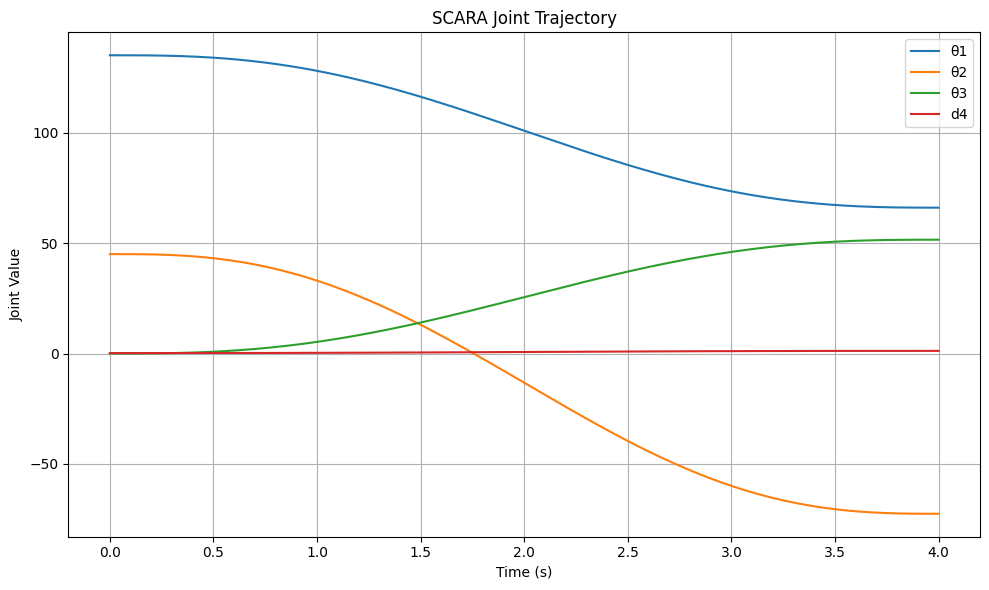

In [ ]:
plt.figure(figsize=(10, 6))
for i, joint in enumerate(["θ1", "θ2", "θ3", "d4"]):
    plt.plot(np.linspace(0, T, N), trajectory[i], label=joint)

plt.xlabel("Time (s)")
plt.ylabel("Joint Value")
plt.title("SCARA Joint Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

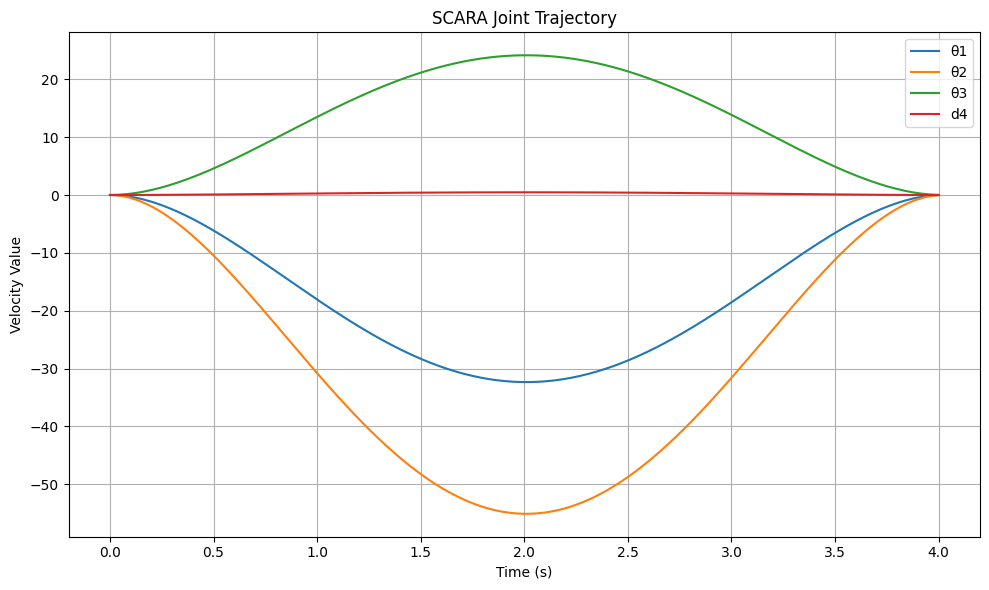

In [ ]:
plt.figure(figsize=(10, 6))
for i, joint in enumerate(["θ1", "θ2", "θ3", "d4"]):
    plt.plot(np.linspace(0, T, N), velocity[i], label=joint)

plt.xlabel("Time (s)")
plt.ylabel("Velocity Value")
plt.title("SCARA Joint Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

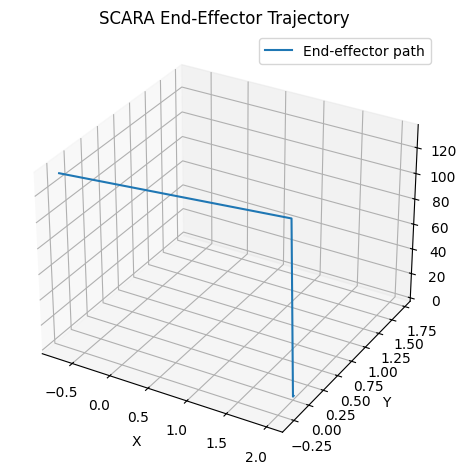

In [ ]:
positions = []

for theta in trajectory:  # shape: (N, 4)
    matexps = [
        se3.matexp(j, q, B_i)
        for j, q, B_i in zip(scara.joint, theta, B)
    ]
    T = se3.matsb(M, matexps)
    pos = T[:3, 3]
    positions.append(pos)

positions = np.array(positions)

# 3D 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:,0], positions[:,1], positions[:,2], label='End-effector path')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('SCARA End-Effector Trajectory')
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
def get_joint_positions(joint_angles, B, M, scara):
    
    T = np.eye(4)
    positions = [T[:3, 3]]  # 시작점 (base)

    for i in range(len(scara.joint)):
        T_i = se3.matexp(scara.joint[i], joint_angles[i], B[i])
        T = T @ T_i
        positions.append(T[:3, 3])

    return np.array(positions)  # shape: (5, 3)

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1, 1.5)
ax.set_ylim(-1, 1.5)
ax.set_zlim(0, 1.5)
line, = ax.plot([], [], [], 'o-', linewidth=3)

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

def update(frame):
    theta = trajectory[frame]
    joint_pos = get_joint_positions(theta, B, M, scara)
    line.set_data(joint_pos[:, 0], joint_pos[:, 1])
    line.set_3d_properties(joint_pos[:, 2])
    return line,

ani = FuncAnimation(fig, update, frames=len(trajectory), init_func=init, blit=True, interval=50)
plt.show()

<IPython.core.display.Javascript object>